In [92]:
import numpy as np
import abc
import math

In [82]:
nodes_per_layer = [2,2,1]
bias_value = 1

#testing purposes
np.random.seed(256)

In [31]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivate(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1.0 - x**2

def relu(x):
    return max(x, 0)

def relu_derivative(x):
    return 0 if x <= 0 else x
    
def get_nr_weights(nodes_per_layer):

    nr_weights = 0

    for idx in range(len(nodes_per_layer) - 1):
        current_layer = nodes_per_layer[idx]
        next_layer = nodes_per_layer[idx + 1]

        nr_weights = nr_weights + (current_layer + 1) * next_layer

    return nr_weights



In [32]:
def step(value, threshold):
    return 0 if value < threshold else 1


def mse(weights):

    inputs = np.array([[0,0],[0,1],[1,0],[1,1]])
    expected_output = np.array([[0],[1],[1],[0]])

    misclassified = 0

    predicted = []
    index = 0
    for possible_inputs in inputs:
        val = xor_net(possible_inputs[0], possible_inputs[1], sigmoid, weights)
        predicted.append(val[-1])
        #print(predicted[-1][0])
        #print(step(predicted[-1][0], 0.5))
        misclassified +=  step(predicted[-1][0], 0.5) != expected_output[index][0]
        index += 1
            
    predicted = np.array(predicted)

    error = expected_output - predicted
    error = error * error
    return np.mean(error), misclassified

In [69]:
def UniformDistributionWeight(lower,upper,shape):
    return np.random.uniform(lower, upper, size=shape)
def divide_in_layers_matrix( weights, nodes_per_layer):
    layers = []
    last = 0
    for idx in range(len(nodes_per_layer) - 1):
        current_layer = nodes_per_layer[idx]
        next_layer = nodes_per_layer[idx + 1]
        temp = (current_layer + 1) * next_layer
        layers.append(weights[last : last + temp].reshape(current_layer + 1, next_layer))
        #print("{}:{}".format(last, last + temp))
        last = temp

    return layers
    
def get_nr_weights(nodes_per_layer):

    nr_weights = 0

    for idx in range(len(nodes_per_layer) - 1):
        current_layer = nodes_per_layer[idx]
        next_layer = nodes_per_layer[idx + 1]

        nr_weights = nr_weights + (current_layer + 1) * next_layer

    return nr_weights

In [34]:
weights = UniformDistributionWeight(-1, 1, get_nr_weights(nodes_per_layer))


In [35]:
def xor_net(x1, x2, activity, weights):
    values = [ np.array([bias_value,x1, x2]) ]
    weights = divide_in_layers_matrix(weights, nodes_per_layer)
    w_len = len(weights) - 1
    
    for i in range(w_len):
        net = np.dot(values[i], weights[i])
        output = activity(net)
        #output = np.concatenate((np.array([bias_value]), np.array(output)))
        output = np.concatenate((np.ones(1), np.array(output)))
        values.append(output)

    net = values[len(values) -1].dot(weights[w_len])
    output = activity(net)
    values.append(output)
        
    return values

vals = np.array(xor_net(1.0, 0.0, sigmoid, weights), dtype="object")

In [36]:
def back_prop( y, target, activity_derivative, weights):
    error = target - y[-1]
    delta_vec = [error * activity_derivative(y[-1])]
    weights = divide_in_layers_matrix(weights, nodes_per_layer)
    #print(weights)

    # we need to begin from the back, from the next to last layer
    for i in range(len(nodes_per_layer)-2, 0, -1):
        error = delta_vec[-1].dot(weights[i][1:].T)
        error = error * activity_derivative(y[i][1:])
        delta_vec.append(error)

    # Now we need to set the values from back to front
    #print('delta_vec: ', delta_vec)
    delta_vec.reverse()
    # Finally, we adjust the weights, using the backpropagation 
    deltas = []
    for i in range(len(weights)):
        layer = y[i].reshape(1, nodes_per_layer[i]+1)
        #print('layer ',layer)
        delta = delta_vec[i].reshape(1, nodes_per_layer[i+1])
        #print('layertdelta:\n',layer.T.dot(delta))
        deltas.append(layer.T.dot(delta))


    return deltas


back_prop(vals, 1.0, sigmoid_derivate, weights)

[array([[-0.03509089,  0.02936716],
        [-0.03509089,  0.02936716],
        [ 0.        ,  0.        ]]),
 array([[0.14812249],
        [0.08145243],
        [0.09695126]])]

In [98]:
# Initialization techniques of weights here defined
class WeightInitialization(metaclass=abc.ABCMeta):


    @abc.abstractmethod
    def init(self, shape):
        pass

#ar = UniformDistributionWeight(-1.0, 1.0)
#var.init(9)

class NormalDistributionWeight(WeightInitialization):

    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

    def init(self, shape):
        return np.random.normal(self.mean, self.variance, size = shape)


class GlorotWeight(WeightInitialization):

    def __init__(self, nodes_per_layer, mean):
        weights = np.array([])
        for l in range(len(nodes_per_layer) - 1):
            l1 = nodes_per_layer[l] + 1
            l2 = nodes_per_layer[l  + 1]
            fan_avg = (l1 + l2) / 2
            temp = np.random.normal(mean, 1/ math.sqrt(fan_avg), size = l1 * l2)
            weights = np.append(weights, temp)

        self.weights = np.array(weights).reshape(-1)

    def init(self):
        return self.weights
class HeWeightInitialization(WeightInitialization):

    def __init__(self, nodes_per_layer, mean):
        weights = np.array([])
        for l in range(len(nodes_per_layer) - 1):
            l1 = nodes_per_layer[l] + 1
            l2 = nodes_per_layer[l + 1]
            fan_in =  l1
            temp = np.random.normal(mean, 1/ math.sqrt(2.0/fan_in), size = l1 * l2)
            weights = np.append(weights, temp)

        self.weights = np.array(weights).reshape(-1)

    def init(self):
        return self.weights


    

In [102]:
weights = UniformDistributionWeight(-1.0, 1.0, get_nr_weights(nodes_per_layer))

#var = NormalDistributionWeight(0, 1.0)
#weights = var.init(9)
#var = GlorotWeight(nodes_per_layer,0)
#weights = var.init()
var =   HeWeightInitialization(nodes_per_layer,0)
weights = var.init()
mse_list_he, miss_list = [],[]


inputs = [[0.0, 0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]
expected_output = [ [0.0],[1.0],[1.0],[0.0]]

learning_rate =0.1
#print (divide_in_layers_matrix(weights, nodes_per_layer))

for k in range(50000):


    if (k+1) % 10000 == 0:
        print('epochs: {}'.format(k+1))

    sample = np.random.randint(len(inputs))
    y = xor_net(inputs[sample][0], inputs[sample][1], sigmoid, weights)
    #mse
    
    mse_elem, miss = mse(weights)
    mse_list_he.append(mse_elem)
    miss_list.append(miss)

    # Now we do our back-propagation of the error to adjust the weights:
    target = expected_output[sample]
    #print(y)
    deltas = back_prop(np.array(y), target, sigmoid_derivate, weights)
    flatten_deltas = np.append(deltas[0].flatten(),np.transpose(np.array(deltas[1])).flatten())

    weights += flatten_deltas * learning_rate
    #print(weights)
#print(weights)

C:\Users\danie\AppData\Local\Temp/ipykernel_7244/3557293605.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  deltas = back_prop(np.array(y), target, sigmoid_derivate, weights)


epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
epochs: 50000


Text(0, 0.5, 'MSE')

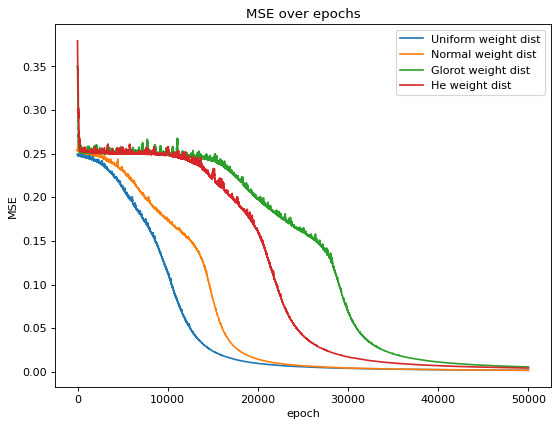

In [103]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(range(len(mse_list_uni)),mse_list_uni,label='Uniform weight dist')
plt.plot(range(len(mse_list_no)),mse_list_no,label='Normal weight dist')
plt.plot(range(len(mse_list_glorot)),mse_list_glorot,label='Glorot weight dist')
plt.plot(range(len(mse_list_he)),mse_list_he,label='He weight dist')
plt.legend()
plt.title('MSE over epochs')
plt.xlabel('epoch')
plt.ylabel('MSE')

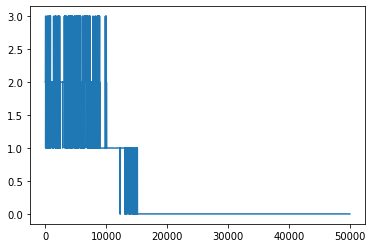

In [55]:
plt.plot(range(len(miss_list)),miss_list)

In [ ]:
def predict_single_data(x, activity):
    val = np.concatenate((np.ones(1).T, np.array(x)))
    #print(weights)
    w = divide_in_layers_matrix(weights, nodes_per_layer)
    for i in range(0, len(w)):
        val = activity(np.dot(val, w[i]))
        val = np.concatenate((np.ones(1).T, np.array(val)))
    return val[1]


def predict(X):
    Y = np.array([]).reshape(0, nodes_per_layer[-1])
    for x in X:
        y = np.array([[predict_single_data(x)]])
        Y = np.vstack((Y,y))
    return Y

print("Final predictsion")
for s in inputs:
    print(s, predict_single_data(s, sigmoid))

Final predictsion
[0.0, 0.0] 0.049996332916655305
[0.0, 1.0] 0.9546579497719521
[1.0, 0.0] 0.9549510798913605
[1.0, 1.0] 0.048386169472889366


a
b
[3306.0, 2666, 3824, 169]


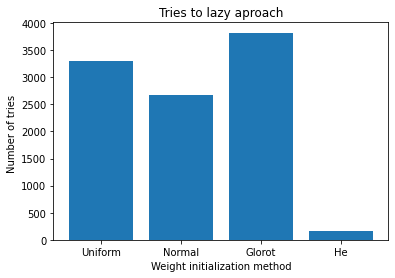

In [127]:
def lazy_aproach():
    res = []
    counter = 0
    done = 5
    while done > 0:
      counter += 1
      weights = UniformDistributionWeight(-5,5, get_nr_weights(nodes_per_layer))
      _, miss = mse(weights)
      if(miss == 0.0):
          done -=1
    res.append(counter/5)
    counter = 0 
    done = False
    while not done:
      counter += 1
      var = NormalDistributionWeight(0, 5.0)
      weights = var.init(9)
      _, miss = mse(weights)
      if(miss == 0.0):
          res.append(counter)
          counter = 0 
          done = True
    print('a')
    done = False
    while not done:
      counter += 1
      var = GlorotWeight(nodes_per_layer,0)
      weights = var.init()*5
      _, miss = mse(weights)
      if(miss == 0.0):
          res.append(counter)
          counter = 0 
          done = True
    print('b')
    done = False
    while not done:
      counter += 1
      var =   HeWeightInitialization(nodes_per_layer,0)
      weights = var.init()*5
      _, miss = mse(weights)
      if(miss == 0.0):
          res.append(counter)
          counter = 0 
          done = True
    print(res)
    plt.bar(['Uniform','Normal','Glorot','He'],res)

    plt.title('Tries to lazy aproach')
    plt.xlabel('Weight initialization method')
    plt.ylabel('Number of tries ')
lazy_aproach()